# Object Classification - Transfer Learning
We will be applying 2 different transfer learning techniques for an image classification task.

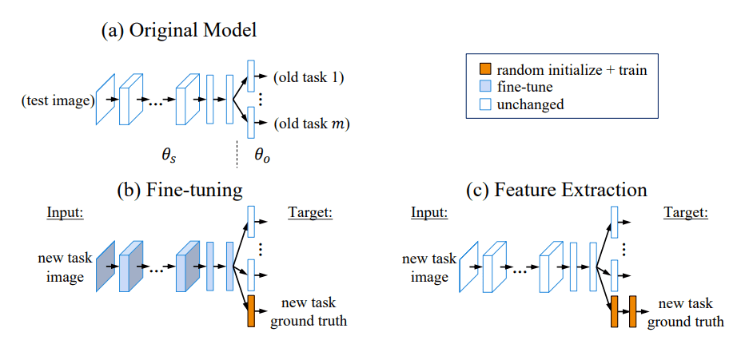

# Transfer Learning Techniques

1. **Fine-Tuning for New Tasks**
    1. Instantiating a Pre-Trained Model with Weights

    2. Replacing Classifier Heads: Replace the output layer (classifier head) with an output layer that one corresponding to the number of categories in the target dataset.
    
    3. Fine-Tuning the Model: Train the new model on the target dataset, adjusting parameters in all layers to optimize performance.

2. **Transfer Learning using Feature Extraction**

    1. Instantiating a Pre-Trained Model with Weights
    
    2. Replacing Classifier Heads:
    Replace the output layer with an output layer corresponding to the number of categories in the target dataset.
    
    3. Task-Specific Training:
    Freeze all layers from the pre-trained model, leaving only the output layer (classifier head) to be trained.

Note: Fine tuning allows for more extensive adaptation to the new task, while partial fine tuning preserves more of the pre-trained model's knowledge. Choose the appropriate technique based on the specific requirements of your project.


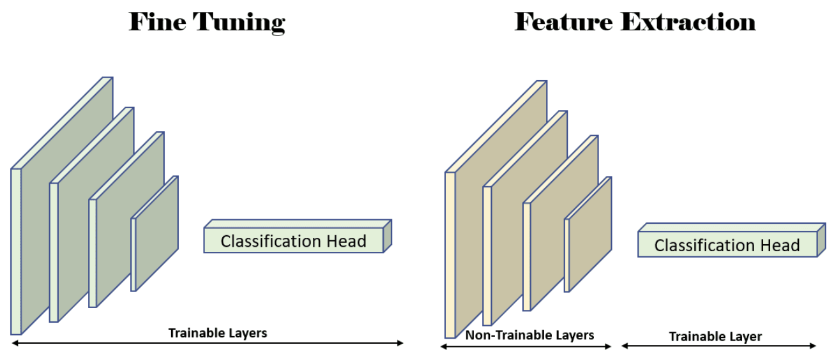

# References
1. https://www.kdnuggets.com/2023/06/practical-guide-transfer-learning-pytorch.html
2. https://github.com/dhruvbird/ml-notebooks/blob/main/Flowers-102-transfer-learning/flowers102-classification-using-pre-trained-models.ipynb
3. https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html#finetuning-the-convnet

# Libraries

In [1]:
import torch
from torch import nn
import torch.quantization
import numpy as np
import torchvision
import os
from PIL import Image
import matplotlib.pyplot as plt
import time
from tempfile import TemporaryDirectory
from torchinfo import summary

from torch.utils.data import ConcatDataset

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## Helper

In [3]:
import os
import urllib


def download_file(url, path=None):
    """helper function to download a file from a URL"""
    if path is None:
        path = url.split("/")[-1]

    if os.path.exists(path):
        print(f"File '{path}' already exists.")
        return

    try:
        urllib.URLopener().retrieve(url, path)
    except:
        urllib.request.urlretrieve(url, path)

    print(f"File '{path}' downloaded successfully.")

# Data
**Accessing Datasets with Torch Vision**
Torch Vision provides an extensive collection of datasets, including popular ones like MNIST, CIFAR10, CIFAR100, and ImageNet, which can be easily accessed and utilized for various machine learning tasks. These datasets are meticulously organized and labeled, ensuring compatibility with Torch Vision.

We could access it with `torchvision.datasets`.

**Importance of Understanding Dataset Structure**
- If you choose to load datasets manually, it is highly recommended to explore the datasets/loader file structure (https://pytorch.org/vision/stable/datasets.html#base-classes-for-custom-datasets). The modules aid in navigate and utilize the datasets, ensuring a seamless experience with Torch Vision. We will delve deeper into this in 3_3_2.

- If you're utilizing Hugging Face, there's an equivalent resource (https://huggingface.co/docs/datasets/index) available to aid in loading datasets.
Unlocking Potential

## Notes
We have two different datasets that can be used interchangeably, just run the required sections.

### Flower102 Datasets
- Via datasets with the `torchvision.datasets` module
- In interest of more balanced training/val split, we would split also set the originally test datasets to train, with additional augmentations embeded with the `torchvision.transforms`


**Dataset Structure**
The dataset files are structured in a specific format, comprising:
- Raw Image Files (.jpg): containing the actual image data
- Image Labels (.mat): containing the corresponding labels for each image

In [4]:
# Loading train and val datasets, to be used as validation datasets
train_data = torchvision.datasets.Flowers102(
    root="data",
    download=True,
    split="train",
    transform=torchvision.transforms.Compose(
        [torchvision.models.VGG16_BN_Weights.IMAGENET1K_V1.transforms()]
    ),
)

val_data = torchvision.datasets.Flowers102(
    root="data",
    download=True,
    split="val",
    transform=torchvision.transforms.Compose(
        [torchvision.models.VGG16_BN_Weights.IMAGENET1K_V1.transforms()]
    ),
)

# Using the test data as training data, will be applying data augmentation for it.
# Utilize data augmentation techniques on the training data to prevent overfitting
# and allow the model to learn the features so that it can perform predictions on unseen data.
# - Color Jitter
# - Horizontal Flip
# - Rotation
# - Shear
test_data = torchvision.datasets.Flowers102(
    root="data",
    download=True,
    split="test",
    transform=torchvision.transforms.Compose(
        [
            torchvision.transforms.RandomHorizontalFlip(p=0.5),
            torchvision.transforms.ColorJitter(brightness=0.3, contrast=0.3),
            torchvision.transforms.RandomAffine(degrees=30, shear=20),
            torchvision.models.VGG16_BN_Weights.IMAGENET1K_V1.transforms(),
        ]
    ),
)

flower_test_dataset = ConcatDataset([train_data, val_data])  # as trainval dataset
flower_train_dataset = test_data  # as training datasets

# Number of datasets
print("Number of training datasets: ", len(flower_train_dataset))
print("Number of test datasets: ", len(flower_test_dataset))

Number of training datasets:  6149
Number of test datasets:  2040


Prepare for training with torch.utils.data.DataLoader class. It represents a Python iterable over a dataset, with support for batching and shuffling.

In [5]:
image_datasets = {}
image_datasets["train"] = flower_train_dataset
image_datasets["val"] = flower_test_dataset
dataloaders = {
    x: torch.utils.data.DataLoader(
        image_datasets[x], batch_size=8, shuffle=True, num_workers=4
    )
    for x in ["train", "val"]
}
dataset_sizes = {x: len(image_datasets[x]) for x in ["train", "val"]}

### Cat & Dogs Dataset
1. Downloading Datasets and Unzipping
- Download the dataset (e.g., cats_vs_dogs) - https://www.tensorflow.org/datasets/catalog/cats_vs_dogs
- Unzip the downloaded file to extract the images
2. Using ImageFolder (Manual Folder)
- Folder with subfolders for each class (e.g., cats and dogs)
- Use the ImageFolder function from PyTorch
- Setup for Train/Val Split & Dataloader

In [6]:
%%capture
download_file("https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip", "data/kagglecatsanddogs_5340.zip")
!cd data && unzip -o kagglecatsanddogs_5340.zip
# Remove corrupted img
!rm data/PetImages/Cat/666.jpg
!rm data/PetImages/Dog/11702.jpg

The ImageFolder script assumed the dataset is organized in the following structure

```
dataset_path/
class1/
image1.jpg
image2.jpg
...
class2/
image1.jpg
image2.jpg
```

In [7]:
from torchvision import datasets, transforms

# Define the transforms to apply to the images
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset_path = 'data/PetImages'
# Load the dataset using ImageFolder
dataset = datasets.ImageFolder(dataset_path, transform=transform)

# Train Val Split
train_dataset, val_dataset = torch.utils.data.random_split(dataset, (0.7, 0.3))
image_datasets['train'] = train_dataset
image_datasets['val'] = val_dataset

# Create data loaders for training and validation
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)
dataset_sizes = {x: len(image_datasets[x]) for x in ["train", "val"]}

dataloaders['train'] = train_loader
dataloaders['val'] = val_loader

*Notes*

If achieving the highest accuracy is your top priority, consider utilizing the test/validation/training split for training. This approach allows for more precise model evaluation and refinement. However, in this demonstration, we shall be focusing on showcasing the fine-tuning/transfer learning setup, so we won't be using this split.

## Plotting the dataset images

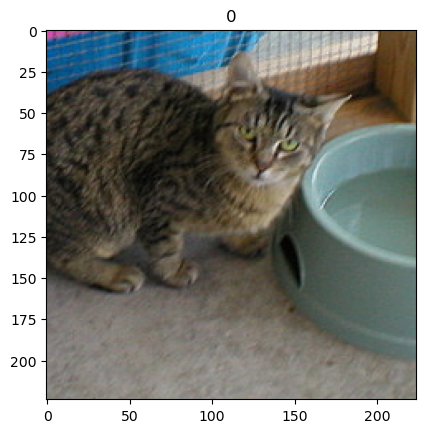

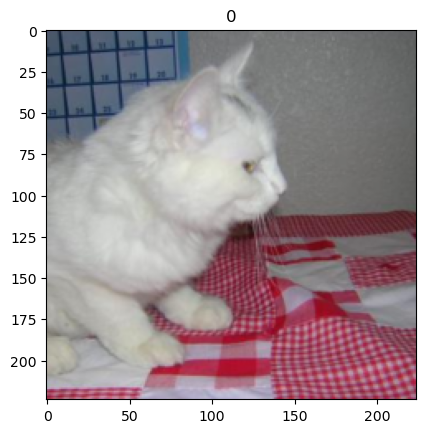

In [8]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


imshow(dataloaders['train'].dataset[10][0], title=dataloaders['train'].dataset[10][1])
imshow(dataloaders['train'].dataset[0][0], title=dataloaders['train'].dataset[0][1])

# Example: Fully Connected (FC) Layer on Pre-Trained Models
- Let's explore examples of loading pre-trained models available in torchvision and examine their classifier heads:

In [9]:
# Load pre-trained models, by default all of the models are trained and tested on ImageNet dataset (with 1000 classes)
vgg16 = torchvision.models.vgg16_bn(weights=None)
resnet50 = torchvision.models.resnet50(weights=None)
resnet152 = torchvision.models.resnet152(weights=None)

# we can examine the last layer of the model via the following code
print("vgg16\n", vgg16.classifier[-1])
print("resnet50\n", resnet50.fc)
print("resnet152\n", resnet152.fc)

vgg16
 Linear(in_features=4096, out_features=1000, bias=True)
resnet50
 Linear(in_features=2048, out_features=1000, bias=True)
resnet152
 Linear(in_features=2048, out_features=1000, bias=True)


# Setup: Learning Rates + Layers (recap)

## Transfer Learning using Feature Extraction - Setup
To utilize transfer learning with feature extraction, we need to:
1. Load a Pre-Trained Model
Load a pre-trained model, such as ResNet18, VGG16, or DenseNet121, using torchvision.models.

2. Modify the Classifier Head
Replace the existing classifier head with a new one, suitable for your specific task. This involves adjusting the output layer to match the number of classes in your dataset.

### Key Point

Only the classifier head requires a learning rate, as the pre-trained model's weights are frozen.

In [10]:
pretrained_model_fe = torchvision.models.resnet50(
    weights=torchvision.models.ResNet50_Weights.IMAGENET1K_V2
)

for param in pretrained_model_fe.parameters():
    param.requires_grad = False

print("Original")
print("\t resnet50\n", pretrained_model_fe.fc)

classifier_layers = [pretrained_model_fe.fc]
# Parameters of newly constructed modules have requires_grad=True by default
# Replace the final layer with a classifier for 102 classes for the Flowers 102 dataset.
pretrained_model_fe.fc = nn.Linear(in_features=2048, out_features=102, bias=True)
new_layers = [pretrained_model_fe.fc]

print("Modified")
print("\t resnet50\n", pretrained_model_fe.fc)

# to device
model_fe = pretrained_model_fe.to(device)

# this reliea on torch info package, which would summarize the model and print the model layers (similar to keras)
summary(
    pretrained_model_fe,
    input_size=(32, 3, 224, 224),
    verbose=0,
    col_names=["input_size", "output_size", "num_params", "trainable"],
)

Original
	 resnet50
 Linear(in_features=2048, out_features=1000, bias=True)
Modified
	 resnet50
 Linear(in_features=2048, out_features=102, bias=True)


Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Trainable
ResNet                                   [32, 3, 224, 224]         [32, 102]                 --                        Partial
├─Conv2d: 1-1                            [32, 3, 224, 224]         [32, 64, 112, 112]        (9,408)                   False
├─BatchNorm2d: 1-2                       [32, 64, 112, 112]        [32, 64, 112, 112]        (128)                     False
├─ReLU: 1-3                              [32, 64, 112, 112]        [32, 64, 112, 112]        --                        --
├─MaxPool2d: 1-4                         [32, 64, 112, 112]        [32, 64, 56, 56]          --                        --
├─Sequential: 1-5                        [32, 64, 56, 56]          [32, 256, 56, 56]         --                        False
│    └─Bottleneck: 2-1                   [32, 64, 56, 56]          [32, 256, 56, 56]         --                        False


Note that only the last layer is trainable

In [11]:
import torch.optim as optim
from torch.optim import lr_scheduler

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_fe = optim.SGD(pretrained_model_fe.fc.parameters(), lr=0.01, momentum=0.9) # 

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler_fe = lr_scheduler.StepLR(optimizer_fe, step_size=7, gamma=0.1)

## Fine-Tuning for New Tasks - Setup

In fine-tuning, we adapt a pre-trained model to a new task by modifying the final layer to match our expected output classes.

### Key Point

The loaded layers are initially set to be trainable, so we don't need to modify their settings. We can proceed with fine-tuning the model without additional configuration.

In [12]:
pretrained_model_ft = torchvision.models.resnet50(
    weights=torchvision.models.ResNet50_Weights.IMAGENET1K_V2
)
classifier_layers = [pretrained_model_ft.fc]
# Parameters of newly constructed modules have requires_grad=True by default
# Replace the final layer with a classifier for 102 classes for the Flowers 102 dataset.
pretrained_model_ft.fc = nn.Linear(in_features=2048, out_features=102, bias=True)
new_layers = [pretrained_model_ft.fc]

# to device
model_ft = pretrained_model_ft.to(device)

# this reliea on torch info package, which would summarize the model and print the model layers (similar to keras)
summary(
    pretrained_model_ft,
    input_size=(32, 3, 224, 224),
    verbose=0,
    col_names=["input_size", "output_size", "num_params", "trainable"],
)

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Trainable
ResNet                                   [32, 3, 224, 224]         [32, 102]                 --                        True
├─Conv2d: 1-1                            [32, 3, 224, 224]         [32, 64, 112, 112]        9,408                     True
├─BatchNorm2d: 1-2                       [32, 64, 112, 112]        [32, 64, 112, 112]        128                       True
├─ReLU: 1-3                              [32, 64, 112, 112]        [32, 64, 112, 112]        --                        --
├─MaxPool2d: 1-4                         [32, 64, 112, 112]        [32, 64, 56, 56]          --                        --
├─Sequential: 1-5                        [32, 64, 56, 56]          [32, 256, 56, 56]         --                        True
│    └─Bottleneck: 2-1                   [32, 64, 56, 56]          [32, 256, 56, 56]         --                        True
│    │ 

Note that all layers is trainable

In [13]:
import torch.optim as optim
from torch.optim import lr_scheduler

criterion = nn.CrossEntropyLoss()

# Observethat all parameters are being optimized
# and that it is decay per layers
optimizer_ft = optim.SGD(pretrained_model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler_ft = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)


# Train Functions
The function performs the following tasks:
1. Creates a temporary directory to save training checkpoints.
2. Saves the initial model parameters as a checkpoint.
3. Initializes variables to track the best model accuracy and training/validation loss and accuracy.
4. Loops through each epoch:
    - Trains the model on the training dataset.
    - Validates the model on the validation dataset.
    - Updates the learning rate scheduler.
5. Saves the model parameters if the validation accuracy improves.

In [14]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, "best_model_params.pt")

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        epoch_dict = {
            "train_loss": [],
            "val_loss": [],
            "train_accuracy": [],
            "val_accuracy": [],
        }
        for epoch in range(num_epochs):
            print(f"Epoch {epoch}/{num_epochs - 1}")
            print("-" * 10)

            # Each epoch has a training and validation phase
            for phase in ["train", "val"]:
                if phase == "train":
                    model.train()  # Set model to training mode
                else:
                    model.eval()  # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == "train"):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == "train":
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == "train":
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")
                if phase == "train":
                    epoch_dict["train_loss"].append(epoch_loss)
                    epoch_dict["train_accuracy"].append(epoch_acc.item())
                else:
                    epoch_dict["val_loss"].append(epoch_loss)
                    epoch_dict["val_accuracy"].append(epoch_acc.item())

                # deep copy the model
                if phase == "val" and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(
            f"Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s"
        )
        print(f"Best val Acc: {best_acc:4f}")

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model, epoch_dict

## Limit training runs to 5 epochs

In [15]:
model_fe, epoch_dict_fe = train_model(
    pretrained_model_fe, criterion, optimizer_fe, exp_lr_scheduler_fe, num_epochs=5
)

Epoch 0/4
----------
train Loss: 0.1090 Acc: 0.9715


/opt/conda/envs/py310cv/lib/python3.10/site-packages/PIL/TiffImagePlugin.py:890: UserWarning: Truncated File Read
  warnings.warn(str(msg))


val Loss: 0.0406 Acc: 0.9871

Epoch 1/4
----------
train Loss: 0.0458 Acc: 0.9837
val Loss: 0.0367 Acc: 0.9877

Epoch 2/4
----------
train Loss: 0.0412 Acc: 0.9855
val Loss: 0.0357 Acc: 0.9873

Epoch 3/4
----------
train Loss: 0.0393 Acc: 0.9865
val Loss: 0.0337 Acc: 0.9879

Epoch 4/4
----------
train Loss: 0.0338 Acc: 0.9891
val Loss: 0.0329 Acc: 0.9879

Training complete in 14m 12s
Best val Acc: 0.987865


In [16]:
model_ft, epoch_dict_ft = train_model(
    pretrained_model_ft, criterion, optimizer_ft, exp_lr_scheduler_ft, num_epochs=5
)

Epoch 0/4
----------
train Loss: 0.2260 Acc: 0.9621
val Loss: 0.0361 Acc: 0.9893

Epoch 1/4
----------
train Loss: 0.0329 Acc: 0.9898
val Loss: 0.0258 Acc: 0.9929

Epoch 2/4
----------
train Loss: 0.0205 Acc: 0.9939
val Loss: 0.0221 Acc: 0.9931

Epoch 3/4
----------
train Loss: 0.0158 Acc: 0.9951
val Loss: 0.0215 Acc: 0.9933

Epoch 4/4
----------
train Loss: 0.0125 Acc: 0.9967
val Loss: 0.0186 Acc: 0.9933

Training complete in 23m 41s
Best val Acc: 0.993332


# Result
- visualize prediction results of the model

In [17]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders["val"]):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 2, 2, images_so_far)
                ax.axis("off")
                ax.set_title(f'predicted: {preds[j]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

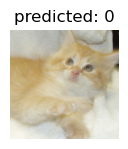

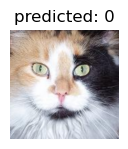

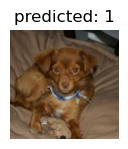

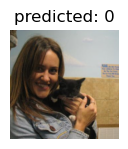

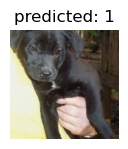

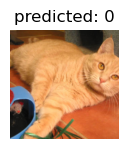

In [18]:
visualize_model(model_ft)

# Evaluation
 

## Comparison of Transfer Learning and Fine-Tuning
We compared two approaches to adapting a pre-trained model to the 2 different datasets:

### Flower Dataset
1. Transfer Learning with Feature Extraction + FC: We achieved an accuracy of 90.1% on the validation dataset by using the pre-trained model as a feature extractor and adding a custom fully connected (FC) layer.

2. Fine-Tuning: By fine-tuning the entire pre-trained model, we achieved a significantly higher accuracy of 97% on the validation dataset.

The results suggest that fine-tuning the whole model provides more freedom and flexibility, leading to better performance on our specific task.

### Dogs and Cats

Indeed, the accuracy differences are relatively small, indicating that the models are performing similarly well. In such cases, Transfer Learning with Feature Extraction can be a suitable approach.

In [19]:
# Extracting the relevant metrics into list
train_accuracy_ft = [float(tensor) for tensor in epoch_dict_ft['train_accuracy']]
val_accuracy_ft = [float(tensor) for tensor in epoch_dict_ft['val_accuracy']]

train_accuracy_fe = [float(tensor) for tensor in epoch_dict_fe['train_accuracy']]
val_accuracy_fe = [float(tensor) for tensor in epoch_dict_fe['val_accuracy']]

Text(0.5, 1.0, 'Fine-Tuning for New Tasks -\n  Train Accuracy vs Val Accuracy')

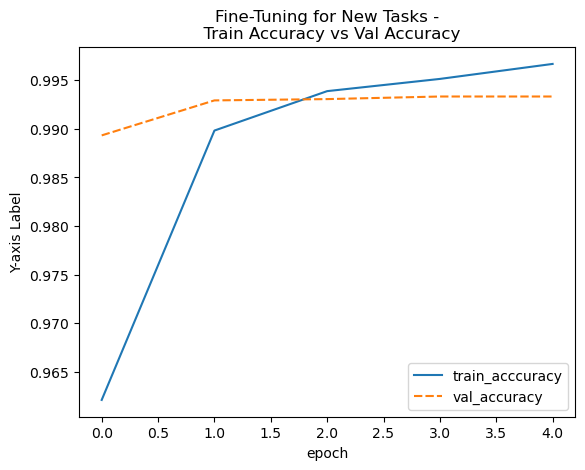

In [20]:
import seaborn as sns
# Plots
sns.lineplot({'train_acccuracy':train_accuracy_ft, 'val_accuracy':val_accuracy_ft})

# Add labels and title
plt.xlabel("epoch")
plt.ylabel("Y-axis Label")
plt.title("Fine-Tuning for New Tasks -\n  Train Accuracy vs Val Accuracy")

Text(0.5, 1.0, 'Transfer Learning using Feature Extraction -\n  Train Accuracy vs Val Accuracy')

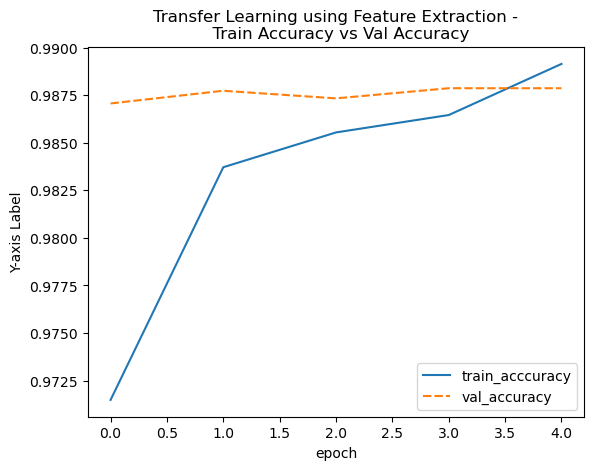

In [21]:
# Plots
sns.lineplot({'train_acccuracy':train_accuracy_fe, 'val_accuracy':val_accuracy_fe})

# Add labels and title
plt.xlabel("epoch")
plt.ylabel("Y-axis Label")
plt.title("Transfer Learning using Feature Extraction -\n  Train Accuracy vs Val Accuracy")

# Exercise
1. Can you modified the code to use VGG16 model instead?
